<a href="https://colab.research.google.com/github/pcarbomestre/SAR-VesselDetection-FisheriesMonitoring/blob/main/improved_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries

The virtual machines used in Colab for the runtimes are ephemeral, so some libraries not preinstalled in Colab environment have to be installed each time we open the notebook. More information about Colab [here](https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/0_colab.ipynb#scrollTo=fPP3Zw5iV2DP).

Detectron2 is a library that provides state-of-the-art detection and segmentation algorithms. It is not installed by default in the Colab environmebt so we have to install it each time we open a session.

More information about it at https://github.com/facebookresearch/detectron2.

In [ ]:
# Install detectron2:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0) # After installation restart Colab's runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-mdniudqb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-mdniudqb
  Resolved https://github.com/facebookresearch/detectron2.git to commit e020497c85873c2b811ac87dd2e4a34a806e4c2b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

Detectron2 is built on top of PyTorch. Therefore, it requires PyTorch to be imported in order to run it. Beside, we will load all detecron2 utilities and other commmon libraries we are going to use.

In [ ]:
import yaml
import torch, torchvision

# Detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data.detection_utils import transform_instance_annotations

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from google.colab.patches import cv2_imshow
import copy
import PIL

We also need to connect to our Google Drive accoung where we have stored our datasets, and where we are going to save our outputs.

In [ ]:
# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Registration of the custom dataset to detectron2

Retrieve previously created datasets compatible with detectron 2

In [ ]:
datasets_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/data/datasets/'

# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = datasets_path + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

The code snippet registers a dataset with Detectron2 by creating a data catalog and setting metadata for the dataset.

In [ ]:
pre = 'ssdd_aug_'

# Register
DatasetCatalog.clear()
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

Store metadata for each dataset.

In [ ]:
# dict
train_dict = get_dict('train')

# metadata instances
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Data augmentation

details on the values specified for the sequence of transformations applied by the mapper function.

- T.Resize((1400,1400), interp=PIL.Image.BILINEAR): Resizes the image to have a height and width of 1400 pixels each using bilinear interpolation.

- T.RandomFlip(prob=0.5, horizontal=False, vertical=True): Flips the image vertically with a probability of 0.5.

- T.RandomFlip(prob=0.5, horizontal=True, vertical=False): Flips the image horizontally with a probability of 0.5.

- T.RandomApply(T.RandomBrightness(0.7, 1.2), prob=0.3): Randomly adjusts the brightness of the image by a factor between 0.7 and 1.2 with a probability of 0.3.

- T.RandomApply(T.RandomContrast(0.7, 1.2), prob=0.3): Randomly adjusts the contrast of the image by a factor between 0.7 and 1.2 with a probability of 0.3.

- T.RandomApply(T.RandomSaturation(0.7, 1.2), prob=0.3): Randomly adjusts the saturation of the image by a factor between 0.7 and 1.2 with a probability of 0.3.

Overall, the sequence of transformations applied by the mapper function is designed to augment the input data with a variety of changes to the image, including resizing, flipping, and adjustments to brightness, contrast, and saturation. This can help improve the performance of computer vision models by exposing them to a wider variety of training data.

The reason for resizing the image from its original size of 800x800 pixels to a size of 1400x1400 pixels using T.Resize((1400,1400), interp=PIL.Image.BILINEAR) is likely to provide additional training data that can help the model learn to generalize better to new images.

By resizing the image to a larger size, the model will see more details and finer-grained features in the image that it might not have seen before. This can help the model learn to recognize objects and patterns more accurately and robustly, which can improve its performance on new, unseen images.

Additionally, resizing the image to a larger size can help mitigate the effects of data loss or degradation that may occur during the augmentation process. Some of the transformations applied during augmentation, such as flipping or rotating the image, can result in portions of the image being lost or obscured. By resizing the image to a larger size, the model has more information to work with and may be better able to recover from these losses

The function below transforms a Detectron2's Dataset, which is a list of dictionaries, into a format compatible with the model. It also augments the training data by applying a series of photometric and geometric transformations to the training images and their associated annotations.

Parameters: dataset_dict (list). The input dataset containing image properties and annotations.

In [ ]:
def mapper(dataset_dict):

    # Make a copy of the input dict.
    dataset_dict = copy.deepcopy(dataset_dict)

    # Load image.
    image = utils.read_image(dataset_dict["file_name"], format="BGR") # Reads the image based on its filename. HWC image | 0-255 | uint8

    # Define a sequence of transformations:
    transformation_list = [T.Resize((1400,1400), interp=PIL.Image.BILINEAR),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomApply(T.RandomBrightness(0.7, 1.2), prob=0.3),
                      T.RandomApply(T.RandomContrast(0.7, 1.2), prob=0.3),
                      T.RandomApply(T.RandomSaturation(0.7, 1.2), prob=0.3)
                      ]

    # Transform image.transforms.ToTensor()(np.array(img))
    auginput = T.AugInput(image) # Define the augmentation input ("image" required, others optional).

    # Transform image.
    auginput, transforms = T.apply_transform_gens(transformation_list, auginput)
    dataset_dict["image"] = torch.as_tensor(copy.deepcopy(auginput.image.transpose(2, 0, 1).astype(dtype=np.uint8))) #dtype=np.uint8 'float32'

    # Transform annotations.
    annos = [
        utils.transform_instance_annotations(obj, [transforms], auginput.image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, auginput.image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

The following function randomly selects an image from a dataset along with its annotations and displays it alongside the augmented image. The augmented image contains new annotations extracted from the training mapper.

In [ ]:
def show_original_augmented(dataset_dict, dataset_metadata):

    # Select a random image.
    random_im_number = random.randint(181, len(dataset_dict))

    # Draw annotations on the original image.
    random_image_4_viz = cv2.imread(dataset_dict[random_im_number]['file_name'])
    viz = Visualizer(random_image_4_viz, dataset_metadata, scale=1., instance_mode=ColorMode.SEGMENTATION)
    out1 = viz.draw_dataset_dict(dataset_dict[random_im_number])
    shape_min = random_image_4_viz.shape[0]
    number_of_gt_boxes = len(dataset_dict[random_im_number]['annotations'])

    # Draw annotations on the augmented image.
    aug_inputs = mapper(dataset_dict[random_im_number])
    random_image_4_viz2 = np.moveaxis(np.array(aug_inputs['image']),0,-1)
    viz = Visualizer(random_image_4_viz2, dataset_metadata, scale=1., instance_mode=ColorMode.SEGMENTATION)
    number_of_new_gt_boxes = len(aug_inputs['instances'])
    out2 = viz.overlay_instances(boxes=aug_inputs['instances'].gt_boxes.tensor.to('cpu'),assigned_colors=['magenta']*number_of_new_gt_boxes)
    shape_max = random_image_4_viz2.shape[0]

    # The instance number in original and augmented image must be the same.
    assert number_of_gt_boxes==number_of_new_gt_boxes

    # Pad the smaller image (original image) with zeros.
    if shape_max<shape_min: shape_min, shape_max = shape_max, shape_min
    frame_width = int((shape_max - shape_min)/2)
    npad = ((frame_width, frame_width), (frame_width, frame_width), (0, 0))
    out_collage = np.hstack((np.pad(out1.get_image(), npad),out2.get_image()))

    # Print image id.
    cv2.putText(
        out_collage, #numpy array on which text is written
        'Image ID: '+  str(dataset_dict[random_im_number]['image_id']), #text
        (int(2*shape_max-shape_max/5), int(0.97*shape_max)), #position at which writing has to start
        cv2.FONT_HERSHEY_SIMPLEX, #font family
        1., #font size
        (255, 0, 0, 0),
        2) #font stroke

    # Display the collage.
    plt.figure(figsize=(30,30))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out_collage);


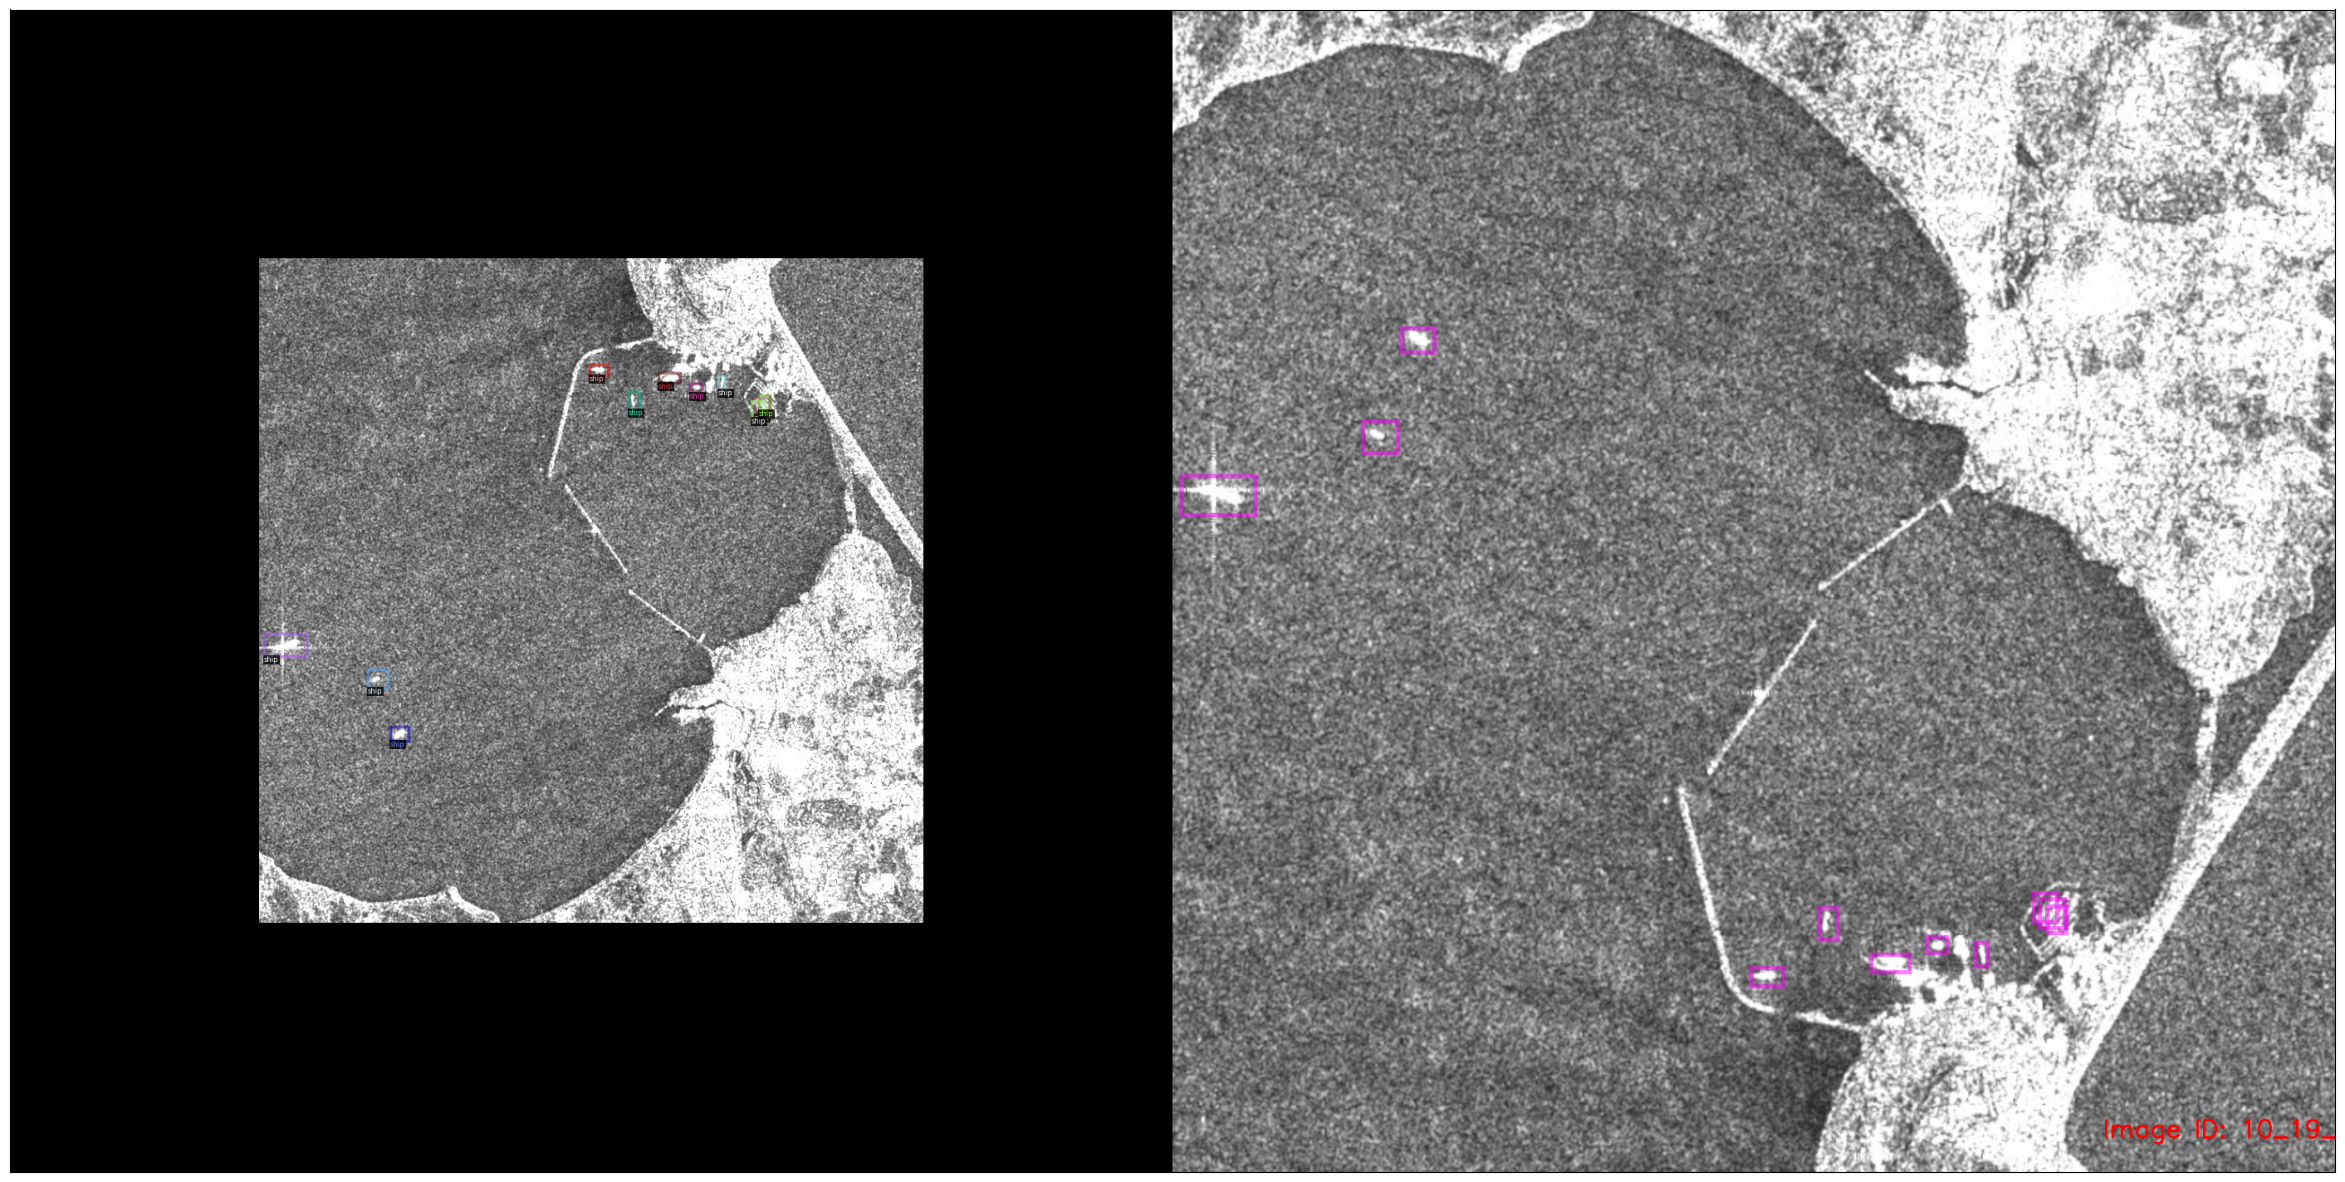

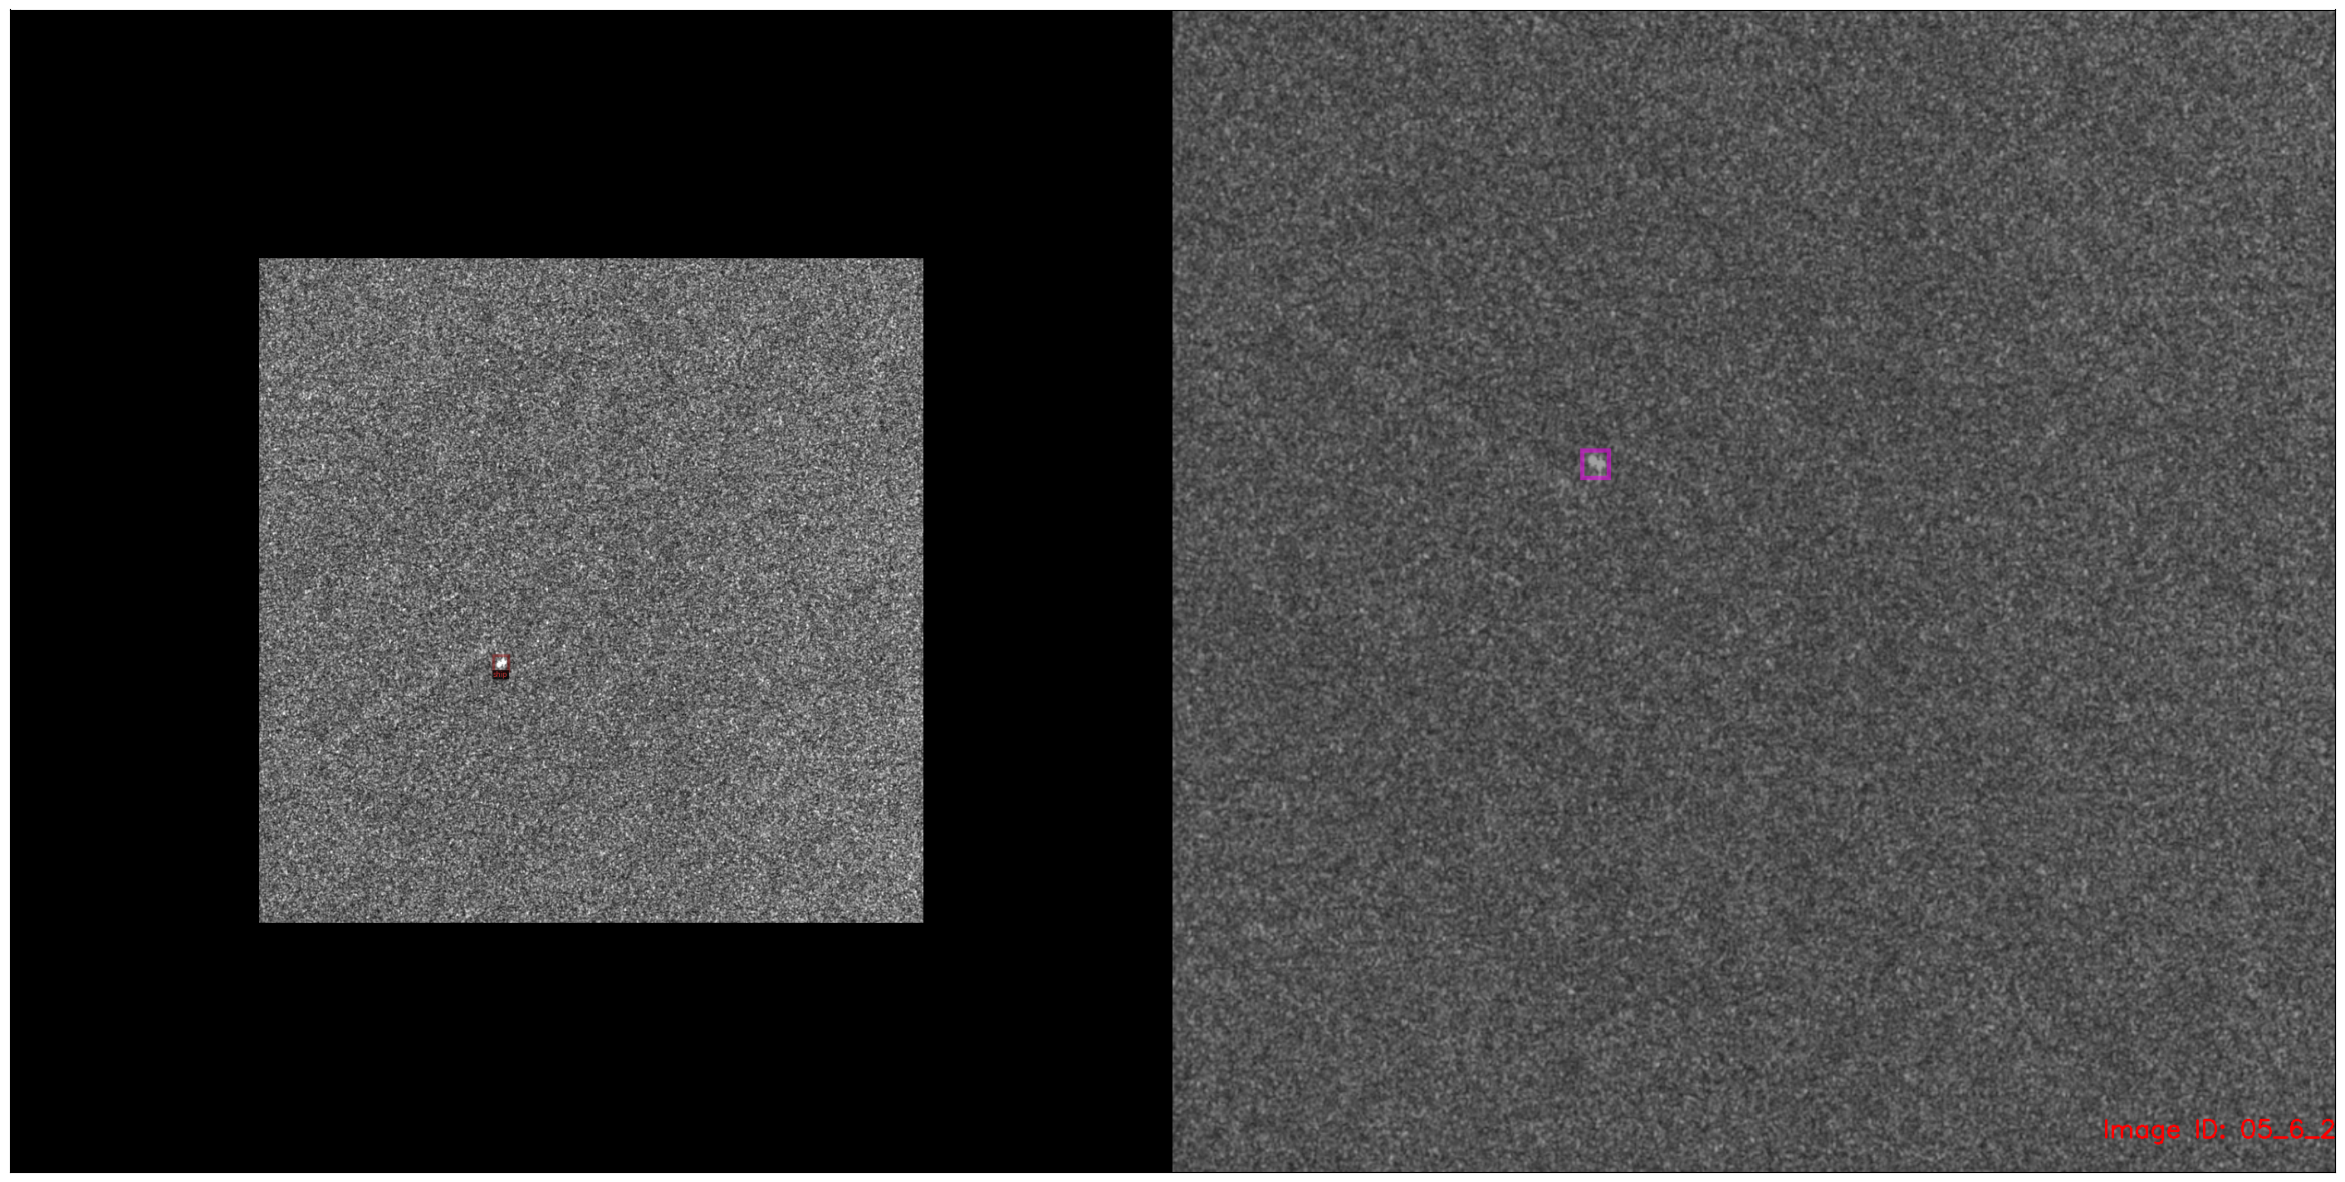

In [ ]:
# Show 2 random images with their corresponding augmented ones:
for i in range(2):show_original_augmented(train_dict, train_metadata)


# Training model

Define the output directory where the model output will be generated.

In [ ]:
%cd /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output
output = '//content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/'
model_name = "./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter"

/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output


The following code sets up the configuration for the Faster R-CNN object detection model using a predefined COCO dataset architecture and our custom dataset, defining various hyperparameters such as the learning rate, batch size, number of classes, and number of iterations for training the model. Detectron configuration information [here](https://detectron2.readthedocs.io/en/latest/modules/config.html).

You can find more information about the Detectron2 Model Zoo [here](https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection).

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Training initializes from a pretrained model on zoo
cfg.SOLVER.IMS_PER_BATCH = 2
# Lowering the learning rate can also help prevent overfitting to the training data by encouraging the model
# to learn more generalizable features that work well on new, unseen data.
cfg.SOLVER.BASE_LR = 0.00025 # default is 0.001
cfg.SOLVER.MAX_ITER = 26000 # final number of iterations choosen after trial and error
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default value for Detectron 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training images without annotations (in our case these should have been removed)

# cfg.SOLVER.MOMENTUM = 0.9 # default value
# cfg.SOLVER.WEIGHT_DECAY = 0.0001 # default value
# cfg.MODEL.DEVICE='cpu' # if you want to run it with the CPU instead of GPU

Assing the output path defined before to the model configuration, and create the directory.

In [ ]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter'

In [ ]:
# RUN ONLY ONCE
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
assert False # Break the execution here if you run all the chunks at once

Execute the training

In [ ]:
class MyTrainer(DefaultTrainer):

    '''Trainer that is based on the 'DefaultTrainer' class but with some
    extra customizations regarding its default methods.'''

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper) #mapper with augmentations


In [ ]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)

[04/30 18:05:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.train()

[04/28 17:07:10 d2.engine.train_loop]: Starting training from iteration 15000


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/28 17:07:40 d2.utils.events]:  eta: 3:58:37  iter: 15019  total_loss: 0.219  loss_cls: 0.07009  loss_box_reg: 0.1448  loss_rpn_cls: 0.0002595  loss_rpn_loc: 0.01209    time: 1.3052  last_time: 1.3023  data_time: 0.0636  last_data_time: 0.0071   lr: 0.00025  max_mem: 6210M
[04/28 17:08:11 d2.utils.events]:  eta: 4:00:17  iter: 15039  total_loss: 0.2505  loss_cls: 0.06706  loss_box_reg: 0.1733  loss_rpn_cls: 0.0004913  loss_rpn_loc: 0.02146    time: 1.3165  last_time: 1.3375  data_time: 0.0102  last_data_time: 0.0075   lr: 0.00025  max_mem: 6210M
[04/28 17:08:38 d2.utils.events]:  eta: 4:02:17  iter: 15059  total_loss: 0.2033  loss_cls: 0.05507  loss_box_reg: 0.1207  loss_rpn_cls: 0.0002823  loss_rpn_loc: 0.01096    time: 1.3273  last_time: 1.3553  data_time: 0.0090  last_data_time: 0.0062   lr: 0.00025  max_mem: 6211M
[04/28 17:09:05 d2.utils.events]:  eta: 4:03:25  iter: 15079  total_loss: 0.3489  loss_cls: 0.08565  loss_box_reg: 0.2082  loss_rpn_cls: 0.0009158  loss_rpn_loc: 0.030

# Training evaluation

### Evaluate training outputs

In [ ]:
%cd /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output
output = '//content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/'
model_name = "./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter"
cfg.OUTPUT_DIR = model_name
experiment_folder = cfg.OUTPUT_DIR

/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output


In [ ]:
def load_json_arr(json_path):

    '''Auxiliary function that transforms the input .json file to a list of dicts.

    Args:
        json_path (str): Output folder that was used during training.
    '''

    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def plot_train_val_loss(experiment_folder):

    '''Plots total and validation losses based on the "metrics.json" file generated
    in training. The total (training) loss is calculated every 20 iterations (default
    step in detectron2 library for loss calculation) and validation loss is calculated
    every cfg.TEST.EVAL_PERIOD iterations.

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    plt.figure(figsize=(16,8))

    # Plot total loss.
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
        [x['total_loss'] for x in experiment_metrics if 'total_loss' in x],
        label="total_loss")

    # Plot validation loss curve.
    xs = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
    ys = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]
    if ys!=[]: plt.plot(xs, ys, c='red', label="validation_loss")

    # Plot validation loss points.
    plt.scatter(xs, ys, marker='*', zorder=10, c='black')

    # Plot labels.
    for x_pos, y_pos in zip(xs, ys):
        label = str(round(y_pos,3))
        while (len(label)<5): label += '0'
        plt.text(x_pos, y_pos+0.05, s=label)

    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()

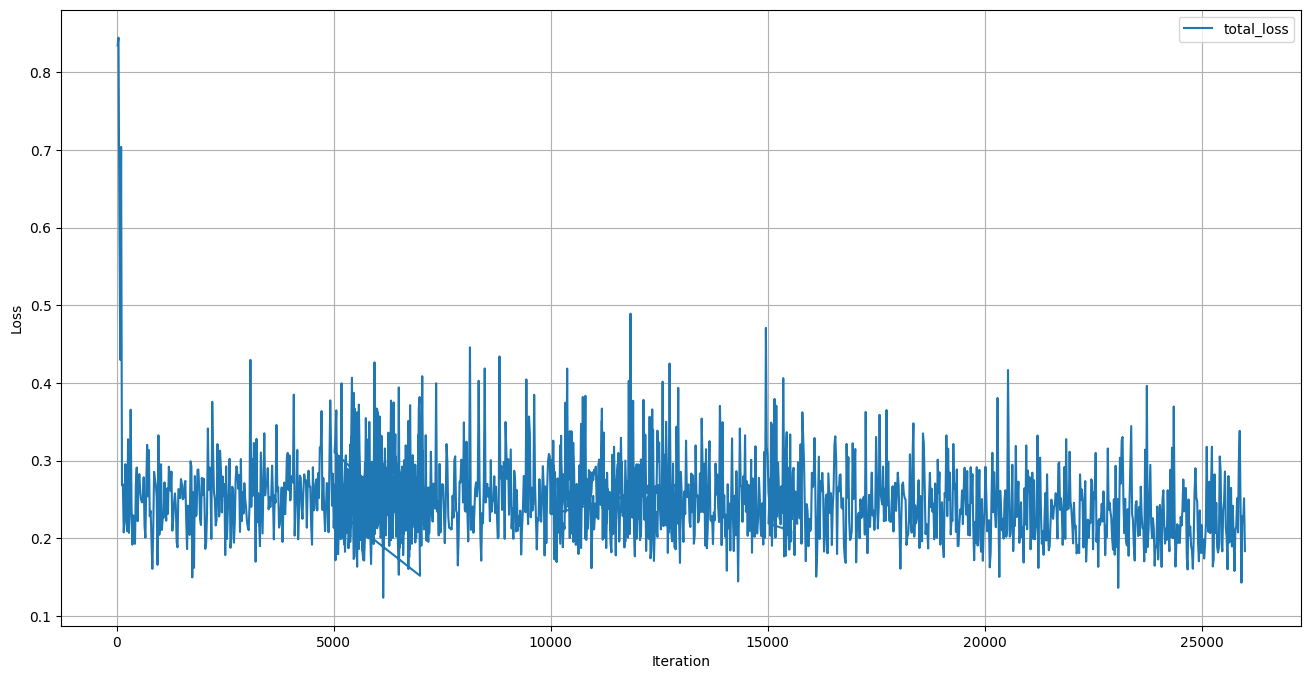

In [ ]:
plot_train_val_loss(experiment_folder)

In [ ]:
def plot_all_losses(experiment_folder, y_log_scale=True, trendlines=True):

    '''Plots the 4 different losses (RPN+ROI Heads) of the Faster-RCNN network
    based on the "metrics.json" file.

    Args:
        experiment_folder (str): Output folder that was used during training.
        y_log_scale (bool): If y-axis is in log scale.
        trendlines (bool): Plot the corresponding polynomial trendlines of the losses.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
    plt.figure(figsize=(16,8))

    losses = ["loss_box_reg", "loss_cls", "loss_rpn_cls", "loss_rpn_loc"]

    # Plot loss.
    for loss in losses:

        # Plot original line.
        xs = [x['iteration'] for x in experiment_metrics if loss in x]
        ys = [x[loss] for x in experiment_metrics if loss in x]
        order = np.argsort(xs)
        p = plt.plot(xs, ys, "-", label=loss, linewidth = 1)

        if trendlines:

            # Plot polynomial trendline.
            z = np.polyfit(np.array(xs)[order.astype(int)],
                     np.array(ys)[order.astype(int)], 2)
            poly = np.poly1d(z)
            plt.plot(np.array(xs)[order.astype(int)],
                     poly(np.array(xs)[order.astype(int)]),
                     color = p[0].get_color(), linewidth=1.5)

    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    if y_log_scale: plt.yscale('log')
    plt.grid()

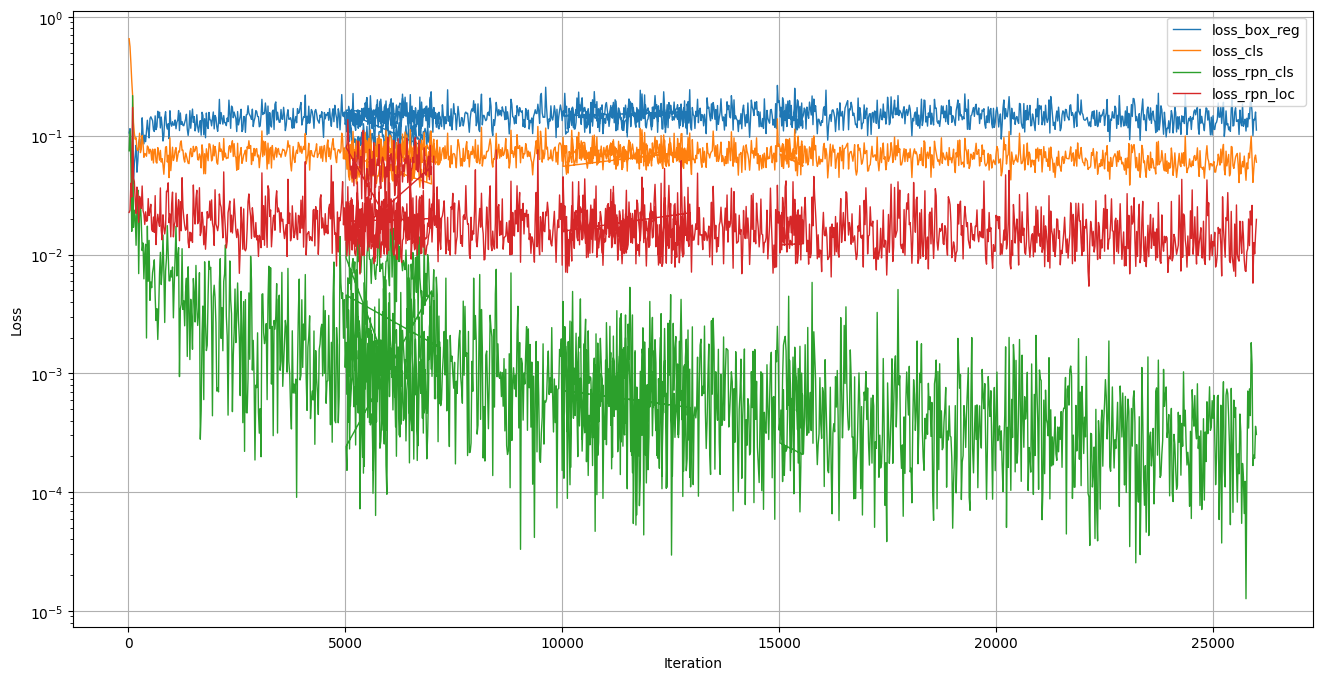

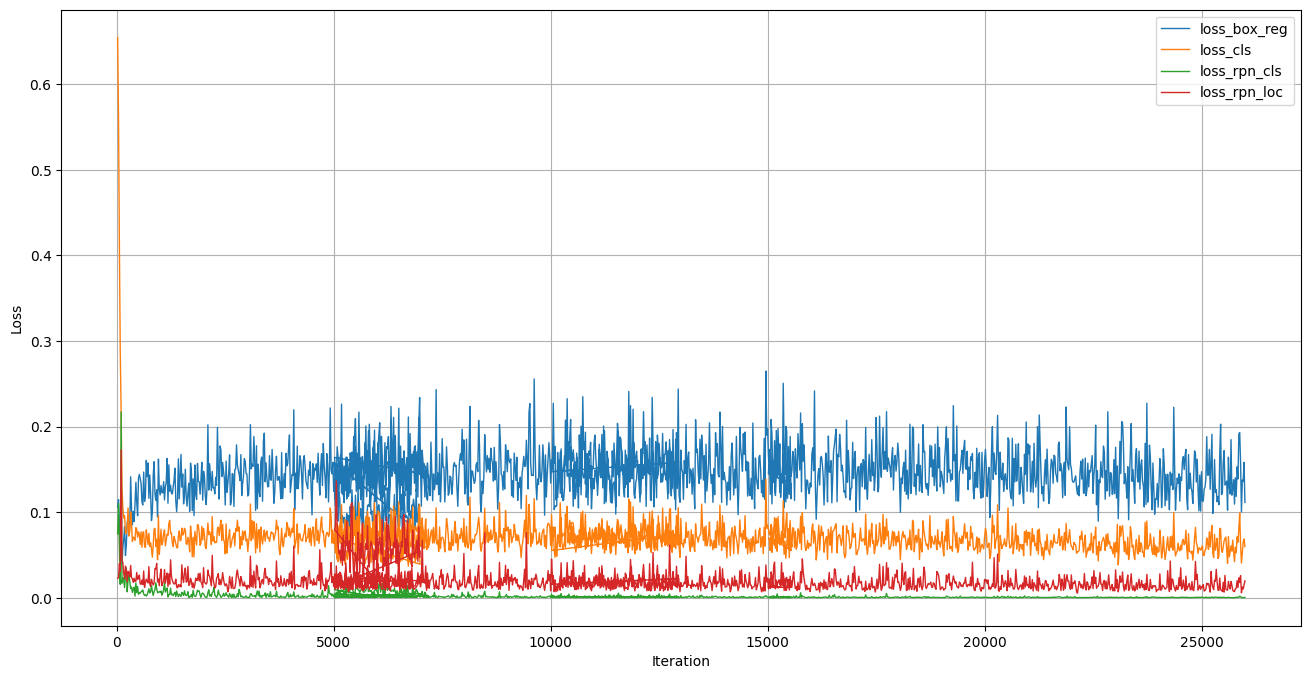

In [ ]:
%matplotlib inline
plot_all_losses(experiment_folder, True, False)
plot_all_losses(experiment_folder, False, False)

In [ ]:
def plot_other_info(experiment_folder):

    '''Plots foreground/ backround accuracy, number of foreground and backround
    samples as well as the numbers of positive and negative anchors existing in a
    batch.

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    mtrics = ["fast_rcnn/cls_accuracy",
              "fast_rcnn/false_negative",
              "fast_rcnn/fg_cls_accuracy",
              "roi_head/num_bg_samples",
              "roi_head/num_fg_samples",
              "rpn/num_neg_anchors",
              "rpn/num_pos_anchors"]

    # Plots.
    fig, ax1 = plt.subplots(figsize=(16,8))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    cmaplist = plt.get_cmap('Dark2').colors

    for i, mtric in enumerate(mtrics):

        xs = [x['iteration'] for x in experiment_metrics if mtric in x]
        ys = [x[mtric] for x in experiment_metrics if mtric in x]

        # Label properties.
        mean = np.array(ys).mean()
        label = str(round(mean, 3))

        # Select in which axis you want to plot each metric.
        if mtric in mtrics[:3]:
            p = ax1.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)
            text_color = p[0].get_color()
            ax1.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6,
                     size=14, path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        else:
            p = ax2.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)
            text_color = p[0].get_color()
            ax2.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6,
                     size=14, path_effects=[pe.withStroke(linewidth=1, foreground="black")])

    # Axis properties
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('FG+BG Accuracy')
    ax2.set_ylabel('Number of FG+BG Samples and Positive/Negative Anchors')
    ax1.grid()

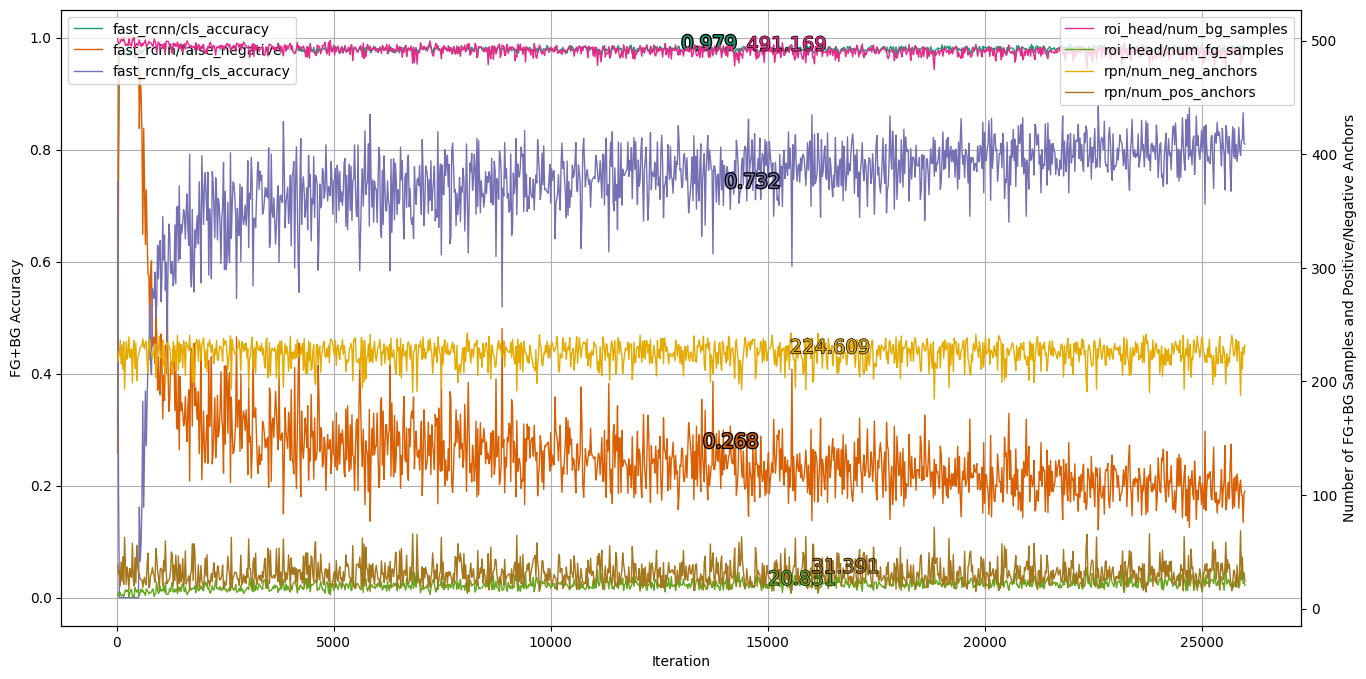

In [ ]:
plot_other_info(experiment_folder)

Alternatively, we can represent de metrics using Tensorboard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_test
%cd ..

### Evaluate performance based on original model setup


We will evaluate its performance using AP metrics implemented in the COCO API.This can only be executed in the same Colab session when the model was trained. This just give us a general idea of the trained model performance over the test dataset. However, we will evaluate its performance on another notebook following Zhang et al., evaluation criteria.

In [ ]:
def mapper_wo(dataset_dict):

    '''
    Mapper without augmentations.
    This mapper is used only for inference.

    Args:
        dataset_dict (list): Image properties and annotations of the input dataset.

    '''

    # Make a copy of the input dict.
    dataset_dict = copy.deepcopy(dataset_dict)

    # Load image.
    image = utils.read_image(dataset_dict["file_name"], format="BGR") # Reads the image based on its filename. HWC image | 0-255 | uint8

    # Transform image.
    auginput = T.AugInput(image) # Define the augmentation input ("image" required, others optional).
    transform = T.Resize((1400, 1400),interp=PIL.Image.BILINEAR)(auginput) #Apply the transformation.
    image = torch.from_numpy(copy.deepcopy(auginput.image.transpose(2, 0, 1)))  #Change channel order from w*h*c to c*w*h

    # Transform annotations.
    annos = [
        transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
        if annotation.get("iscrowd", 0) == 0
    ]

    # Convert annotations to Instances and filter out the empty ones.
    instances = utils.annotations_to_instances(annos, image.shape[1:])

    # Add image and instances to the dictionary.
    dataset_dict["image"] = image #image[0,:,:]because utils.read_image() uses pillow converts the image from grayscale to bgr with 3 identical channels.
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_aug_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test', mapper_wo)

print(inference_on_dataset(trainer.model, val_loader, evaluator))

[04/30 18:13:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/30 18:13:00 d2.data.common]: Serializing 736 elements to byte tensors and concatenating them all ...
[04/30 18:13:00 d2.data.common]: Serialized dataset takes 0.25 MiB
[04/30 18:13:00 d2.evaluation.evaluator]: Start inference on 736 batches


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/30 18:13:06 d2.evaluation.evaluator]: Inference done 11/736. Dataloading: 0.0096 s/iter. Inference: 0.2774 s/iter. Eval: 0.0004 s/iter. Total: 0.2874 s/iter. ETA=0:03:28
[04/30 18:13:11 d2.evaluation.evaluator]: Inference done 29/736. Dataloading: 0.0063 s/iter. Inference: 0.2758 s/iter. Eval: 0.0003 s/iter. Total: 0.2825 s/iter. ETA=0:03:19
[04/30 18:13:16 d2.evaluation.evaluator]: Inference done 47/736. Dataloading: 0.0053 s/iter. Inference: 0.2771 s/iter. Eval: 0.0003 s/iter. Total: 0.2829 s/iter. ETA=0:03:14
[04/30 18:13:21 d2.evaluation.evaluator]: Inference done 65/736. Dataloading: 0.0058 s/iter. Inference: 0.2778 s/iter. Eval: 0.0003 s/iter. Total: 0.2841 s/iter. ETA=0:03:10
[04/30 18:13:26 d2.evaluation.evaluator]: Inference done 83/736. Dataloading: 0.0055 s/iter. Inference: 0.2782 s/iter. Eval: 0.0003 s/iter. Total: 0.2842 s/iter. ETA=0:03:05
[04/30 18:13:31 d2.evaluation.evaluator]: Inference done 101/736. Dataloading: 0.0052 s/iter. Inference: 0.2790 s/iter. Eval: 0.00

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_aug_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test', mapper_wo)

print(inference_on_dataset(trainer.model, val_loader, evaluator))